In [1]:
%matplotlib inline
import numpy as np
import sklearn
import matplotlib
import matplotlib.pylab as plt
import sklearn.linear_model
import seaborn

Let's generate some data with a simple model. There's a binary sensitive attribute, a predictor uncorrelated with the attribute, a predictor correlated with the attribute, and an outcome that's correlated with both predictors.

In [2]:
n = 10000
attribute = np.random.rand(n) > 0.5

predictor1 = np.random.randn(n) 

disparity_scale = 1.0
predictor2 = np.random.randn(n) + attribute * disparity_scale

noise_scale = 1.0
noise = np.random.randn(n) * noise_scale

y = predictor1 + predictor2 + noise
#y = predictor1 + attribute + noise
yd = y > np.random.rand(n)


/Users/roban/Library/Python/2.7/lib/python/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


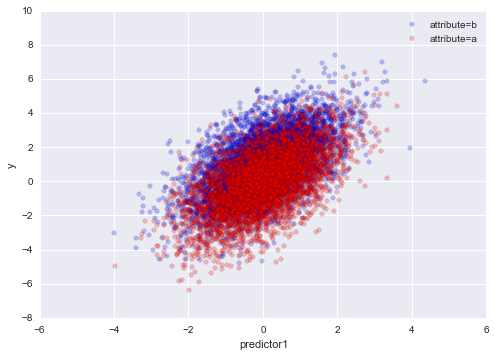

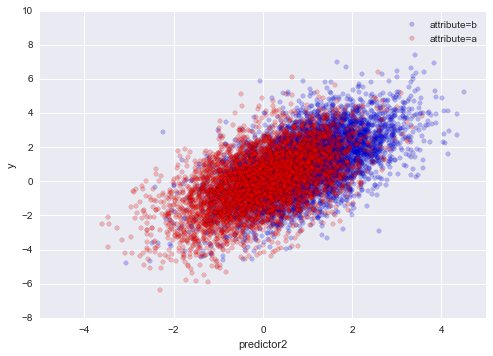

In [3]:
plt.scatter(predictor1[attribute], y[attribute], c='b', alpha=0.25, label='attribute=b')
plt.scatter(predictor1[np.logical_not(attribute)], y[np.logical_not(attribute)], c='r', alpha=0.25, label='attribute=a')
plt.xlabel('predictor1')
plt.ylabel('y')
plt.legend(loc='best')
plt.figure()
plt.scatter(predictor2[attribute], y[attribute], c='b', alpha=0.25, label='attribute=b')
plt.scatter(predictor2[np.logical_not(attribute)], y[np.logical_not(attribute)], c='r', alpha=0.25, label='attribute=a')
plt.xlabel('predictor2')
plt.ylabel('y')
plt.legend(loc='best')

Above you can see that the probability of being in the positive class (y) is correlated with the attribute and with one of the predictors. This results in points with attribute=b being much more likely to be in the positive class.

In [4]:
print "Condition Positive Fraction for each attribute class: (a,b)"
yd[np.logical_not(attribute)].mean(), yd[attribute].mean()

Condition Positive Fraction for each attribute class: (a,b)


(0.39877179080824088, 0.61449919224555738)

So now let's fit a logistic regression model to these predictors and the binary outcome.

In [5]:
X = np.vstack([predictor1, predictor2]).T
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, yd)
clf.coef_

array([[ 1.63774072,  1.63570101]])

In [6]:
p = clf.predict_proba(X)[:,1]
ydhat = p > 0.5

In [7]:
fpr_all, tpr_all, t_all = sklearn.metrics.roc_curve(yd, p)
fpr_falseclass, tpr_falseclass, t_falseclass = sklearn.metrics.roc_curve(yd[np.logical_not(attribute)], p[np.logical_not(attribute)])
fpr_trueclass, tpr_trueclass, t_trueclass = sklearn.metrics.roc_curve(yd[attribute], p[attribute])

Now plot an ROC curve. We see that according to the ROC curve, our model works *better* for the subset with attribute=b! That doesn't look like discrimination against b!

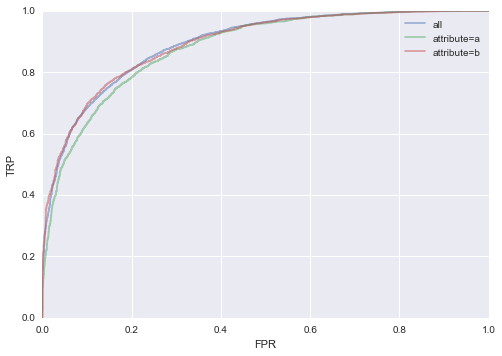

In [8]:
plt.plot(fpr_all, tpr_all, label='all', alpha=0.5)
plt.plot(fpr_falseclass, tpr_falseclass, label='attribute=a', alpha=0.5)
plt.plot(fpr_trueclass, tpr_trueclass, label='attribute=b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("FPR")
plt.ylabel("TRP")

Let's check the true positive rate (TPR) vs the score threshold. We find again that the true positive rate is *better* at all thresholds for the attribute=b group:

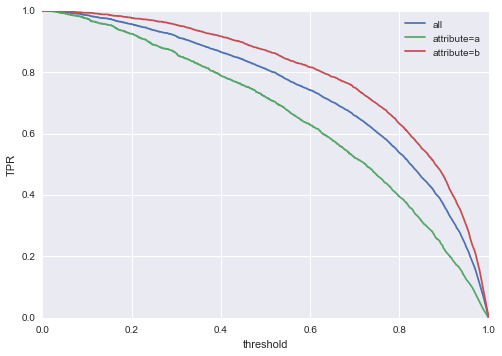

In [9]:
plt.plot(t_all, tpr_all, label='all')
plt.plot(t_falseclass, tpr_falseclass, label='attribute=a')
plt.plot(t_trueclass, tpr_trueclass, label='attribute=b')
plt.legend(loc='best')
plt.xlabel("threshold")
plt.ylabel("TPR")

Now let's check the falst positive rate (FPR) vs the score threshold. We find again that the falst positive rate is much higher at all thresholds for the attribute=b group. If the positive class is *bad*, that means we're *much* more likely to *falsely* classify a *good* member of group b as bad, compared to a good member of group a.

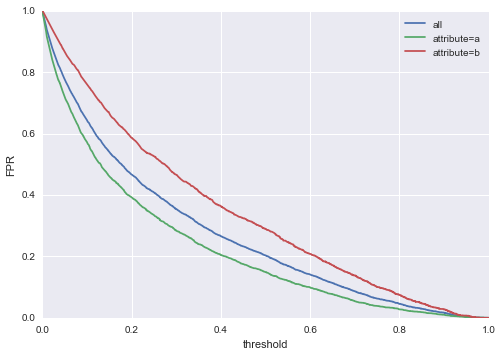

In [10]:
plt.plot(t_all, fpr_all, label='all')
plt.plot(t_falseclass, fpr_falseclass, label='attribute=a')
plt.plot(t_trueclass, fpr_trueclass, label='attribute=b')
plt.legend(loc='best')
plt.xlabel("threshold")
plt.ylabel("FPR")

At a threshold of 0.5, the false positive rate P(classified bad | actually good) is 14% for group a and 27% for group b.

In [11]:
def fpr(y_true, y_pred):
    fp = (np.logical_not(y_true) & y_pred).sum()
    cn = np.logical_not(y_true).sum()
    return fp * 1.0 / cn

print "False positive rates for all, attribute=a, attribute=b"
fpr(yd, ydhat), fpr(yd[np.logical_not(attribute)], ydhat[np.logical_not(attribute)]), fpr(yd[attribute], ydhat[attribute])

False positive rates for all, attribute=a, attribute=b


(0.20327669902912621, 0.14892915980230642, 0.28968046097433209)

So we've demonstrated that a model trained on *correct* labels, and not directly trained on the sensitive attribute, can be biased against actually good members a group, merely because that group has a higher positive label fraction. And this bias can be hidden, because it's only revealed by comparing false positive rates, not other performance metrics.